In [1]:
import numpy as np
import matplotlib.pyplot as plt

from environments.pricing_env import PricingEnvironment
from learners.greedy import Greedy
from learners.ucb import UCB
from learners.normal_gamma_ts import NormalGammaTS

from data_generators.basic_generator import BasicDataGenerator
%matplotlib inline 

In [2]:
data_gen = BasicDataGenerator(filename='src/basic001.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'{prices=}')
print(f'{bids=}')
print(f'{margins=}')
print(f'{conv_rates=}')
print(f'{costs_per_click=}')
print(f'{n_clicks=}')
print(f'{aggr_tau=}')

sel_bid = 3
print(f'\nSelected bid: {bids[sel_bid]}({sel_bid})')
print(f'Fixed CPC: {costs_per_click[sel_bid]}')
print(f'Fixed num_clicks: {n_clicks[sel_bid]} -> {np.rint(n_clicks[sel_bid]).astype(int)}')

print('\n',15*'-','SIMULATION PARAMS', '-'*15)
T = 1000
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.03, 0.04, 0.07, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0]
margins=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
conv_rates=array([0.217, 0.214, 0.208, 0.197, 0.183, 0.164, 0.136, 0.125, 0.116,
       0.098])
costs_per_click=array([0.03 , 0.04 , 0.069, 0.097, 0.189, 0.44 , 0.627, 0.799, 1.105,
       1.375])
n_clicks=array([ 30.107,  38.897,  62.152,  81.492, 126.508, 181.541, 196.399,
       202.562, 206.463, 207.274])
aggr_tau=array([2.95, 2.58, 2.21, 1.84, 1.47, 1.1 , 0.91, 0.75, 0.7 , 0.7 ])

Selected bid: 0.1(3)
Fixed CPC: 0.097
Fixed num_clicks: 81.492 -> 81

 --------------- SIMULATION PARAMS ---------------
Time horizon: 1000 days
Num. experiments: 10


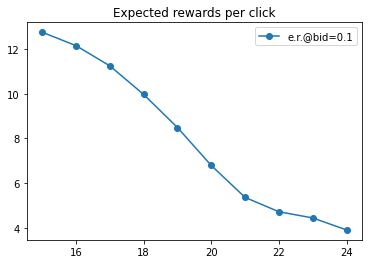

In [3]:
plt.figure()
env_b = PricingEnvironment(n_arms=len(prices),
                             conversion_rates=conv_rates,
                             cost_per_click=costs_per_click[sel_bid],
                             n_clicks=np.rint(n_clicks[sel_bid]).astype(int),
                             margins=margins, 
                             tau=aggr_tau) 
plt.plot(prices, env_b.expected_rewards, '-o', label=f"e.r.@bid={bids[sel_bid]}")
plt.title(f"Expected rewards per click")
plt.legend(loc='best')
plt.show()

In [4]:
rewards_per_experiment = {}
rewards_per_experiment['Greedy'] = []
rewards_per_experiment['UCB'] = []
rewards_per_experiment['TS'] = []

In [5]:
n_arms = len(prices) 
env_params = {
        'n_arms': n_arms,
        'conversion_rates': conv_rates,
        'cost_per_click': costs_per_click[sel_bid],
        'n_clicks': np.rint(n_clicks[sel_bid]).astype(int),
        'margins': margins, 
        'tau': aggr_tau
    }
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    test_instances = [
        ("Greedy", Greedy(n_arms), PricingEnvironment(**env_params)),
        ("UCB", UCB(n_arms), PricingEnvironment(**env_params)),
        #("TS", NormalGammaTS(n_arms), PricingEnvironment(**env_params))
    ]
    
    for t in range(T):
        for name, learner, env in test_instances:
            pulled_arm = learner.pull_arm()
            daily_reward = env.round(pulled_arm)
            for r in daily_reward:
                learner.update(pulled_arm, r)
            if t % 30 == 0 and name != 'Greedy':
                print(f'[exp#{e}] t: {t}\n{name}\n{pulled_arm=}\n{np.sum(daily_reward)=}')
                print(30*'-')

    for learner_name, learner, _ in test_instances:
        rewards_per_experiment[learner_name].append(learner.collected_rewards)

[exp#0] t: 0
UCB
pulled_arm=0
np.sum(daily_reward)=6.443099323988076
------------------------------
[exp#0] t: 30
UCB
pulled_arm=7
np.sum(daily_reward)=2.0917404088308182
------------------------------
[exp#0] t: 60
UCB
pulled_arm=8
np.sum(daily_reward)=3.1566341587999283
------------------------------
[exp#0] t: 90
UCB
pulled_arm=2
np.sum(daily_reward)=5.428829344056346
------------------------------
[exp#0] t: 120
UCB
pulled_arm=0
np.sum(daily_reward)=5.850307231223348
------------------------------
[exp#0] t: 150
UCB
pulled_arm=3
np.sum(daily_reward)=3.9959635367222264
------------------------------
[exp#0] t: 180
UCB
pulled_arm=8
np.sum(daily_reward)=2.431251530687478
------------------------------
[exp#0] t: 210
UCB
pulled_arm=4
np.sum(daily_reward)=3.3031815746043978
------------------------------
[exp#0] t: 240
UCB
pulled_arm=4
np.sum(daily_reward)=4.149702496960842
------------------------------
[exp#0] t: 270
UCB
pulled_arm=7
np.sum(daily_reward)=2.051770198679506
------------

[exp#2] t: 390
UCB
pulled_arm=1
np.sum(daily_reward)=5.5001205378802975
------------------------------
[exp#2] t: 420
UCB
pulled_arm=5
np.sum(daily_reward)=1.2834755005626088
------------------------------
[exp#2] t: 450
UCB
pulled_arm=9
np.sum(daily_reward)=1.8201390760756289
------------------------------
[exp#2] t: 480
UCB
pulled_arm=2
np.sum(daily_reward)=6.760305881664251
------------------------------
[exp#2] t: 510
UCB
pulled_arm=9
np.sum(daily_reward)=2.5502978336683997
------------------------------
[exp#2] t: 540
UCB
pulled_arm=2
np.sum(daily_reward)=5.498223724206728
------------------------------
[exp#2] t: 570
UCB
pulled_arm=0
np.sum(daily_reward)=5.539327384894019
------------------------------
[exp#2] t: 600
UCB
pulled_arm=0
np.sum(daily_reward)=5.7935937886140625
------------------------------
[exp#2] t: 630
UCB
pulled_arm=5
np.sum(daily_reward)=2.2497782635888575
------------------------------
[exp#2] t: 660
UCB
pulled_arm=5
np.sum(daily_reward)=2.1436141309553536
----

[exp#4] t: 780
UCB
pulled_arm=1
np.sum(daily_reward)=6.343314930178395
------------------------------
[exp#4] t: 810
UCB
pulled_arm=1
np.sum(daily_reward)=4.021876072021048
------------------------------
[exp#4] t: 840
UCB
pulled_arm=1
np.sum(daily_reward)=2.140996131961332
------------------------------
[exp#4] t: 870
UCB
pulled_arm=1
np.sum(daily_reward)=6.049484717534595
------------------------------
[exp#4] t: 900
UCB
pulled_arm=9
np.sum(daily_reward)=1.9343643509586457
------------------------------
[exp#4] t: 930
UCB
pulled_arm=1
np.sum(daily_reward)=3.108917239947608
------------------------------
[exp#4] t: 960
UCB
pulled_arm=1
np.sum(daily_reward)=6.637955886747412
------------------------------
[exp#4] t: 990
UCB
pulled_arm=1
np.sum(daily_reward)=4.561813703106969
------------------------------
[exp#5] t: 0
UCB
pulled_arm=1
np.sum(daily_reward)=7.0877772321400245
------------------------------
[exp#5] t: 30
UCB
pulled_arm=9
np.sum(daily_reward)=1.2068594625921525
-----------

[exp#7] t: 150
UCB
pulled_arm=1
np.sum(daily_reward)=5.427186509923148
------------------------------
[exp#7] t: 180
UCB
pulled_arm=0
np.sum(daily_reward)=8.226124164027524
------------------------------
[exp#7] t: 210
UCB
pulled_arm=5
np.sum(daily_reward)=3.7852132980796536
------------------------------
[exp#7] t: 240
UCB
pulled_arm=3
np.sum(daily_reward)=5.0403244819533795
------------------------------
[exp#7] t: 270
UCB
pulled_arm=0
np.sum(daily_reward)=7.501042034776544
------------------------------
[exp#7] t: 300
UCB
pulled_arm=7
np.sum(daily_reward)=4.5561741470896875
------------------------------
[exp#7] t: 330
UCB
pulled_arm=1
np.sum(daily_reward)=5.880544948469726
------------------------------
[exp#7] t: 360
UCB
pulled_arm=6
np.sum(daily_reward)=3.33766939794517
------------------------------
[exp#7] t: 390
UCB
pulled_arm=0
np.sum(daily_reward)=5.001536036188567
------------------------------
[exp#7] t: 420
UCB
pulled_arm=5
np.sum(daily_reward)=2.69482792009686
----------

[exp#9] t: 540
UCB
pulled_arm=7
np.sum(daily_reward)=3.3755011206519154
------------------------------
[exp#9] t: 570
UCB
pulled_arm=9
np.sum(daily_reward)=3.267833969000381
------------------------------
[exp#9] t: 600
UCB
pulled_arm=9
np.sum(daily_reward)=3.1020251139465147
------------------------------
[exp#9] t: 630
UCB
pulled_arm=7
np.sum(daily_reward)=1.5879170894441752
------------------------------
[exp#9] t: 660
UCB
pulled_arm=0
np.sum(daily_reward)=7.95331713685594
------------------------------
[exp#9] t: 690
UCB
pulled_arm=0
np.sum(daily_reward)=7.968406447656892
------------------------------
[exp#9] t: 720
UCB
pulled_arm=0
np.sum(daily_reward)=5.574380517198473
------------------------------
[exp#9] t: 750
UCB
pulled_arm=3
np.sum(daily_reward)=3.53268531813206
------------------------------
[exp#9] t: 780
UCB
pulled_arm=0
np.sum(daily_reward)=6.568919542307608
------------------------------
[exp#9] t: 810
UCB
pulled_arm=0
np.sum(daily_reward)=8.37751505625735
-----------

/home/filippo/anaconda3/envs/dia-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/filippo/anaconda3/envs/dia-env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


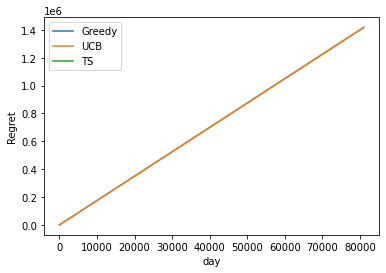

In [9]:
opt_per_round = np.max(test_instances[0][2].get_expected_rewards())
opt_per_day = opt_per_round * env_params['n_clicks']

#opt = [opt_per_day]*T

# Plotting the results
plt.figure()
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(np.cumsum(np.mean(opt_per_day - rewards_per_experiment['Greedy'], axis=0)))
plt.plot(np.cumsum(np.mean(opt_per_day - rewards_per_experiment['UCB'], axis=0)))
plt.plot(np.cumsum(np.mean(opt_per_day - rewards_per_experiment['TS'], axis=0)))
plt.legend(["Greedy", "UCB", "TS"])

In [7]:
opt_per_round * env_params['n_clicks']

17.576999999999998

In [8]:
env_params['n_clicks']

81